# Профильное задание в ВК
Требовалось разработать метод поиска коротких заставок в сериалах.

Заставка сериала — повторяющийся от серии к серии фрагмент, который связан с представлением данного сериала. Они бывают от нескольких секунд до минут. Здесь нас интересует только короткий вариант заставки, где обычно только показывают название сериала. Нам надо определить время начала и конца такой заставки.

Подход, идеи и пайплайн описаны в README. Здесь только краткие комментарии и заголовки каждого блока =)

In [2]:
import os
import json
import numpy as np
from moviepy import VideoFileClip
import torch
import torchvision.transforms as T
import torchvision.models as models
import cv2
from tqdm import tqdm


In [3]:
# Настройки
input_dir = "movie_dir"  # Папка с видео
json_path = "merged_labels.json"  # Аннотации
output_dir = "features_dataset"  # Куда сохранять
max_duration = 14 * 60

In [4]:
# Загружаем модель ResNet
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)
model.eval()

# Трансформации для входного кадра
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    weights.transforms()
])

In [5]:
def time_to_seconds(time_str):
    # time_str формат "0:00:05"
    h, m, s = map(int, time_str.split(":"))
    return h * 3600 + m * 60 + s

# функция получения метки (Positive/Negative) для каждой секунды
def get_label_for_second(video_id, sec, annotations):
    start_sec = time_to_seconds(annotations[video_id]["start"])
    end_sec = time_to_seconds(annotations[video_id]["end"])
    if start_sec <= sec < end_sec:
        return 1
    else:
        return 0

# функция для сохранения признаков с целевыми метками
def save_features_labels(video_id, features, labels):
    save_path = os.path.join(output_dir, f"{video_id}.pt")
    torch.save({'features': features, 'labels': labels}, save_path)
    print(f"Сохранил признаки и метки для {video_id} в {save_path}")


In [6]:
with open(json_path, "r", encoding="utf-8") as f:
    annotations = json.load(f)

In [11]:
# цикл обработки каждого видео в признаковое пространство (1 видео поврежденное 😢 (серия сериала Звездный путь), однако даже так, модель на нем предскажет удовлетворяющий результат)
for video_id in tqdm(annotations.keys()):
    video_path = os.path.join(input_dir, video_id, f"{video_id}.mp4")
    with VideoFileClip(video_path) as clip:
        duration = min(clip.duration, max_duration)
        video_features = []
        video_labels = []

        for sec in range(int(duration)):
            frame = clip.get_frame(sec)
            frame_tensor = transform(frame).unsqueeze(0)

            with torch.no_grad():
                feats = model(frame_tensor) 

            video_features.append(feats.squeeze(0)) 
            label = get_label_for_second(video_id, sec, annotations)
            video_labels.append(label)

        features_tensor = torch.stack(video_features) 
        labels_tensor = torch.tensor(video_labels)  

        # Сохраняем признаки и метки
        save_features_labels(video_id, features_tensor, labels_tensor)

print("Обработка завершена.")

  1%|          | 1/110 [01:57<3:34:17, 117.96s/it]

Сохранил признаки и метки для -220020068_456249220 в features_dataset\-220020068_456249220.pt


  2%|▏         | 2/110 [04:05<3:42:26, 123.58s/it]

Сохранил признаки и метки для -220020068_456249373 в features_dataset\-220020068_456249373.pt


  3%|▎         | 3/110 [05:21<3:01:51, 101.98s/it]

Сохранил признаки и метки для -220020068_456249231 в features_dataset\-220020068_456249231.pt


  4%|▎         | 4/110 [06:38<2:42:21, 91.90s/it] 

Сохранил признаки и метки для -220020068_456255339 в features_dataset\-220020068_456255339.pt


  5%|▍         | 5/110 [08:46<3:04:05, 105.20s/it]

Сохранил признаки и метки для -220020068_456249284 в features_dataset\-220020068_456249284.pt


  5%|▌         | 6/110 [10:05<2:46:30, 96.06s/it] 

Сохранил признаки и метки для -220020068_456241671 в features_dataset\-220020068_456241671.pt


  6%|▋         | 7/110 [11:24<2:35:30, 90.59s/it]

Сохранил признаки и метки для -220020068_456249192 в features_dataset\-220020068_456249192.pt


  7%|▋         | 8/110 [13:32<2:54:24, 102.59s/it]

Сохранил признаки и метки для -220020068_456249257 в features_dataset\-220020068_456249257.pt


  8%|▊         | 9/110 [15:43<3:07:36, 111.45s/it]

Сохранил признаки и метки для -220020068_456249375 в features_dataset\-220020068_456249375.pt


  9%|▉         | 10/110 [17:00<2:48:02, 100.82s/it]

Сохранил признаки и метки для -220020068_456256475 в features_dataset\-220020068_456256475.pt


 10%|█         | 11/110 [18:18<2:34:36, 93.70s/it] 

Сохранил признаки и метки для -220020068_456249206 в features_dataset\-220020068_456249206.pt


 11%|█         | 12/110 [20:28<2:51:03, 104.73s/it]

Сохранил признаки и метки для -220020068_456249376 в features_dataset\-220020068_456249376.pt


 12%|█▏        | 13/110 [21:45<2:35:48, 96.38s/it] 

Сохранил признаки и метки для -220020068_456241758 в features_dataset\-220020068_456241758.pt


 13%|█▎        | 14/110 [23:58<2:51:42, 107.31s/it]

Сохранил признаки и метки для -220020068_456249243 в features_dataset\-220020068_456249243.pt


 14%|█▎        | 15/110 [26:08<3:01:06, 114.38s/it]

Сохранил признаки и метки для -220020068_456249344 в features_dataset\-220020068_456249344.pt


 15%|█▍        | 16/110 [27:29<2:43:14, 104.20s/it]

Сохранил признаки и метки для -220020068_456249716 в features_dataset\-220020068_456249716.pt


 15%|█▌        | 17/110 [28:44<2:27:44, 95.32s/it] 

Сохранил признаки и метки для -220020068_456249259 в features_dataset\-220020068_456249259.pt


 16%|█▋        | 18/110 [29:59<2:16:47, 89.21s/it]

Сохранил признаки и метки для -220020068_456255389 в features_dataset\-220020068_456255389.pt


 17%|█▋        | 19/110 [31:13<2:08:20, 84.62s/it]

Сохранил признаки и метки для -220020068_456249720 в features_dataset\-220020068_456249720.pt


 18%|█▊        | 20/110 [33:15<2:23:54, 95.94s/it]

Сохранил признаки и метки для -220020068_456249272 в features_dataset\-220020068_456249272.pt


 19%|█▉        | 21/110 [35:28<2:38:49, 107.07s/it]

Сохранил признаки и метки для -220020068_456249318 в features_dataset\-220020068_456249318.pt


 20%|██        | 22/110 [37:44<2:49:54, 115.85s/it]

Сохранил признаки и метки для -220020068_456249222 в features_dataset\-220020068_456249222.pt


 21%|██        | 23/110 [40:36<3:12:32, 132.78s/it]

Сохранил признаки и метки для -220020068_456249358 в features_dataset\-220020068_456249358.pt


 22%|██▏       | 24/110 [43:32<3:28:54, 145.76s/it]

Сохранил признаки и метки для -220020068_456249204 в features_dataset\-220020068_456249204.pt


 23%|██▎       | 25/110 [46:23<3:36:48, 153.04s/it]

Сохранил признаки и метки для -220020068_456249309 в features_dataset\-220020068_456249309.pt


 24%|██▎       | 26/110 [48:02<3:11:57, 137.11s/it]

Сохранил признаки и метки для -220020068_456255346 в features_dataset\-220020068_456255346.pt


 25%|██▍       | 27/110 [50:49<3:21:56, 145.98s/it]

Сохранил признаки и метки для -220020068_456249214 в features_dataset\-220020068_456249214.pt


 25%|██▌       | 28/110 [53:40<3:29:43, 153.46s/it]

Сохранил признаки и метки для -220020068_456249275 в features_dataset\-220020068_456249275.pt


 26%|██▋       | 29/110 [55:22<3:06:19, 138.02s/it]

Сохранил признаки и метки для -220020068_456255393 в features_dataset\-220020068_456255393.pt


 27%|██▋       | 30/110 [58:12<3:16:36, 147.45s/it]

Сохранил признаки и метки для -220020068_456249208 в features_dataset\-220020068_456249208.pt


 28%|██▊       | 31/110 [1:00:59<3:22:04, 153.48s/it]

Сохранил признаки и метки для -220020068_456249368 в features_dataset\-220020068_456249368.pt


 29%|██▉       | 32/110 [1:02:38<2:58:19, 137.18s/it]

Сохранил признаки и метки для -220020068_456257137 в features_dataset\-220020068_456257137.pt


 30%|███       | 33/110 [1:05:28<3:08:28, 146.86s/it]

Сохранил признаки и метки для -220020068_456249216 в features_dataset\-220020068_456249216.pt


 31%|███       | 34/110 [1:07:06<2:47:33, 132.28s/it]

Сохранил признаки и метки для -220020068_456249350 в features_dataset\-220020068_456249350.pt


 32%|███▏      | 35/110 [1:08:45<2:32:57, 122.36s/it]

Сохранил признаки и метки для -220020068_456255410 в features_dataset\-220020068_456255410.pt


 33%|███▎      | 36/110 [1:11:32<2:47:19, 135.67s/it]

Сохранил признаки и метки для -220020068_456249313 в features_dataset\-220020068_456249313.pt


 34%|███▎      | 37/110 [1:13:12<2:32:14, 125.13s/it]

Сохранил признаки и метки для -220020068_456255411 в features_dataset\-220020068_456255411.pt


 35%|███▍      | 38/110 [1:15:59<2:45:00, 137.51s/it]

Сохранил признаки и метки для -220020068_456249211 в features_dataset\-220020068_456249211.pt


 35%|███▌      | 39/110 [1:18:48<2:54:06, 147.13s/it]

Сохранил признаки и метки для -220020068_456249352 в features_dataset\-220020068_456249352.pt


 36%|███▋      | 40/110 [1:21:38<2:59:29, 153.86s/it]

Сохранил признаки и метки для -220020068_456249219 в features_dataset\-220020068_456249219.pt


 37%|███▋      | 41/110 [1:24:24<3:01:08, 157.51s/it]

Сохранил признаки и метки для -220020068_456249315 в features_dataset\-220020068_456249315.pt


 38%|███▊      | 42/110 [1:26:02<2:38:16, 139.65s/it]

Сохранил признаки и метки для -220020068_456249692 в features_dataset\-220020068_456249692.pt


 39%|███▉      | 43/110 [1:27:44<2:23:16, 128.30s/it]

Сохранил признаки и метки для -220020068_456255338 в features_dataset\-220020068_456255338.pt


 40%|████      | 44/110 [1:29:23<2:11:24, 119.46s/it]

Сохранил признаки и метки для -220020068_456255399 в features_dataset\-220020068_456255399.pt


 41%|████      | 45/110 [1:32:09<2:24:41, 133.56s/it]

Сохранил признаки и метки для -220020068_456249233 в features_dataset\-220020068_456249233.pt


 42%|████▏     | 46/110 [1:33:44<2:10:03, 121.93s/it]

Сохранил признаки и метки для -220020068_456255414 в features_dataset\-220020068_456255414.pt


 43%|████▎     | 47/110 [1:35:21<2:00:20, 114.61s/it]

Сохранил признаки и метки для -220020068_456249693 в features_dataset\-220020068_456249693.pt


 44%|████▎     | 48/110 [1:36:57<1:52:24, 108.79s/it]

Сохранил признаки и метки для -220020068_456241755 в features_dataset\-220020068_456241755.pt


 45%|████▍     | 49/110 [1:38:36<1:47:45, 105.99s/it]

Сохранил признаки и метки для -220020068_456255340 в features_dataset\-220020068_456255340.pt


 45%|████▌     | 50/110 [1:40:15<1:43:47, 103.79s/it]

Сохранил признаки и метки для -220020068_456241756 в features_dataset\-220020068_456241756.pt


 46%|████▋     | 51/110 [1:41:53<1:40:20, 102.04s/it]

Сохранил признаки и метки для -220020068_456256016 в features_dataset\-220020068_456256016.pt


 47%|████▋     | 52/110 [1:43:31<1:37:28, 100.84s/it]

Сохранил признаки и метки для -220020068_456249732 в features_dataset\-220020068_456249732.pt


 48%|████▊     | 53/110 [1:45:08<1:34:53, 99.88s/it] 

Сохранил признаки и метки для -220020068_456255332 в features_dataset\-220020068_456255332.pt


 49%|████▉     | 54/110 [1:46:44<1:31:54, 98.48s/it]

Сохранил признаки и метки для -220020068_456241672 в features_dataset\-220020068_456241672.pt


 50%|█████     | 55/110 [1:48:22<1:30:08, 98.34s/it]

Сохранил признаки и метки для -220020068_456255341 в features_dataset\-220020068_456255341.pt


 51%|█████     | 56/110 [1:49:57<1:27:49, 97.59s/it]

Сохранил признаки и метки для -220020068_456256013 в features_dataset\-220020068_456256013.pt


 52%|█████▏    | 57/110 [1:50:59<1:16:37, 86.74s/it]

Сохранил признаки и метки для -220020068_456248657 в features_dataset\-220020068_456248657.pt


 53%|█████▎    | 58/110 [1:52:35<1:17:33, 89.49s/it]

Сохранил признаки и метки для -220020068_456241673 в features_dataset\-220020068_456241673.pt


 54%|█████▎    | 59/110 [1:54:10<1:17:39, 91.37s/it]

Сохранил признаки и метки для -220020068_456255402 в features_dataset\-220020068_456255402.pt


 55%|█████▍    | 60/110 [1:55:48<1:17:43, 93.28s/it]

Сохранил признаки и метки для -220020068_456257139 в features_dataset\-220020068_456257139.pt


 55%|█████▌    | 61/110 [1:57:26<1:17:12, 94.55s/it]

Сохранил признаки и метки для -220020068_456254621 в features_dataset\-220020068_456254621.pt


 56%|█████▋    | 62/110 [1:58:43<1:11:25, 89.28s/it]

Сохранил признаки и метки для -220020068_456252055 в features_dataset\-220020068_456252055.pt


 57%|█████▋    | 63/110 [2:00:22<1:12:11, 92.17s/it]

Сохранил признаки и метки для -220020068_456249739 в features_dataset\-220020068_456249739.pt


 58%|█████▊    | 64/110 [2:01:39<1:07:18, 87.80s/it]

Сохранил признаки и метки для -220020068_456255403 в features_dataset\-220020068_456255403.pt


 59%|█████▉    | 65/110 [2:02:54<1:03:00, 84.01s/it]

Сохранил признаки и метки для -220020068_456256012 в features_dataset\-220020068_456256012.pt


 60%|██████    | 66/110 [2:04:10<59:50, 81.59s/it]  

Сохранил признаки и метки для -220020068_456257141 в features_dataset\-220020068_456257141.pt


 61%|██████    | 67/110 [2:05:27<57:27, 80.17s/it]

Сохранил признаки и метки для -220020068_456241851 в features_dataset\-220020068_456241851.pt


 62%|██████▏   | 68/110 [2:06:42<55:04, 78.67s/it]

Сохранил признаки и метки для -220020068_456256571 в features_dataset\-220020068_456256571.pt


 63%|██████▎   | 69/110 [2:07:57<52:58, 77.53s/it]

Сохранил признаки и метки для -220020068_456256019 в features_dataset\-220020068_456256019.pt


 64%|██████▎   | 70/110 [2:09:12<51:13, 76.85s/it]

Сохранил признаки и метки для -220020068_456255344 в features_dataset\-220020068_456255344.pt


 65%|██████▍   | 71/110 [2:10:28<49:47, 76.59s/it]

Сохранил признаки и метки для -220020068_456255405 в features_dataset\-220020068_456255405.pt


 65%|██████▌   | 72/110 [2:11:46<48:38, 76.81s/it]

Сохранил признаки и метки для -220020068_456255391 в features_dataset\-220020068_456255391.pt


 66%|██████▋   | 73/110 [2:13:04<47:40, 77.30s/it]

Сохранил признаки и метки для -220020068_456241844 в features_dataset\-220020068_456241844.pt


 67%|██████▋   | 74/110 [2:14:23<46:34, 77.62s/it]

Сохранил признаки и метки для -220020068_456254282 в features_dataset\-220020068_456254282.pt


C:\Users\user\DataspellProjects\yandex\venv\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:190: UserWarning: In file movie_dir\-220020068_456239859\-220020068_456239859.mp4, 6220800 bytes wanted but 0 bytes read at frame index 11208 (out of a total 90888 frames), at time 467.00/3787.04 sec. Using the last valid frame instead.
  warnings.warn(
C:\Users\user\DataspellProjects\yandex\venv\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:190: UserWarning: In file movie_dir\-220020068_456239859\-220020068_456239859.mp4, 6220800 bytes wanted but 0 bytes read at frame index 11232 (out of a total 90888 frames), at time 468.00/3787.04 sec. Using the last valid frame instead.
  warnings.warn(
C:\Users\user\DataspellProjects\yandex\venv\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:190: UserWarning: In file movie_dir\-220020068_456239859\-220020068_456239859.mp4, 6220800 bytes wanted but 0 bytes read at frame index 11256 (out of a total 90888 frames), at time 469.00/3787.04 sec. Usi

Сохранил признаки и метки для -220020068_456239859 в features_dataset\-220020068_456239859.pt


 69%|██████▉   | 76/110 [2:18:32<55:18, 97.61s/it]   

Сохранил признаки и метки для -220020068_456255392 в features_dataset\-220020068_456255392.pt


 70%|███████   | 77/110 [2:19:47<49:58, 90.86s/it]

Сохранил признаки и метки для -220020068_456241845 в features_dataset\-220020068_456241845.pt


 71%|███████   | 78/110 [2:21:05<46:22, 86.97s/it]

Сохранил признаки и метки для -220020068_456255766 в features_dataset\-220020068_456255766.pt


 72%|███████▏  | 79/110 [2:22:23<43:32, 84.29s/it]

Сохранил признаки и метки для -220020068_456256003 в features_dataset\-220020068_456256003.pt


 73%|███████▎  | 80/110 [2:23:41<41:15, 82.52s/it]

Сохранил признаки и метки для -220020068_456257136 в features_dataset\-220020068_456257136.pt


 74%|███████▎  | 81/110 [2:25:00<39:25, 81.58s/it]

Сохранил признаки и метки для -220020068_456241846 в features_dataset\-220020068_456241846.pt


 75%|███████▍  | 82/110 [2:26:23<38:09, 81.75s/it]

Сохранил признаки и метки для -220020068_456255767 в features_dataset\-220020068_456255767.pt


 75%|███████▌  | 83/110 [2:27:45<36:53, 82.00s/it]

Сохранил признаки и метки для -220020068_456254537 в features_dataset\-220020068_456254537.pt


 76%|███████▋  | 84/110 [2:29:11<36:03, 83.22s/it]

Сохранил признаки и метки для -220020068_456255394 в features_dataset\-220020068_456255394.pt


 77%|███████▋  | 85/110 [2:30:32<34:24, 82.57s/it]

Сохранил признаки и метки для -220020068_456255409 в features_dataset\-220020068_456255409.pt


 78%|███████▊  | 86/110 [2:31:48<32:09, 80.38s/it]

Сохранил признаки и метки для -220020068_456241847 в features_dataset\-220020068_456241847.pt


 79%|███████▉  | 87/110 [2:33:02<30:08, 78.64s/it]

Сохранил признаки и метки для -220020068_456255773 в features_dataset\-220020068_456255773.pt


 80%|████████  | 88/110 [2:34:15<28:13, 76.97s/it]

Сохранил признаки и метки для -220020068_456256005 в features_dataset\-220020068_456256005.pt


 81%|████████  | 89/110 [2:35:30<26:41, 76.25s/it]

Сохранил признаки и метки для -220020068_456256868 в features_dataset\-220020068_456256868.pt


 82%|████████▏ | 90/110 [2:36:44<25:14, 75.72s/it]

Сохранил признаки и метки для -220020068_456255349 в features_dataset\-220020068_456255349.pt


 83%|████████▎ | 91/110 [2:38:02<24:07, 76.21s/it]

Сохранил признаки и метки для -220020068_456255395 в features_dataset\-220020068_456255395.pt


 84%|████████▎ | 92/110 [2:39:14<22:29, 74.97s/it]

Сохранил признаки и метки для -220020068_456255779 в features_dataset\-220020068_456255779.pt


 85%|████████▍ | 93/110 [2:40:29<21:17, 75.13s/it]

Сохранил признаки и метки для -220020068_456256893 в features_dataset\-220020068_456256893.pt


 85%|████████▌ | 94/110 [2:41:44<20:01, 75.07s/it]

Сохранил признаки и метки для -220020068_456241682 в features_dataset\-220020068_456241682.pt


 86%|████████▋ | 95/110 [2:43:02<18:56, 75.75s/it]

Сохранил признаки и метки для -220020068_456255396 в features_dataset\-220020068_456255396.pt


 87%|████████▋ | 96/110 [2:44:16<17:36, 75.46s/it]

Сохранил признаки и метки для -220020068_456254614 в features_dataset\-220020068_456254614.pt


 88%|████████▊ | 97/110 [2:45:30<16:13, 74.86s/it]

Сохранил признаки и метки для -220020068_456241849 в features_dataset\-220020068_456241849.pt


 89%|████████▉ | 98/110 [2:46:43<14:51, 74.27s/it]

Сохранил признаки и метки для -220020068_456255780 в features_dataset\-220020068_456255780.pt


 90%|█████████ | 99/110 [2:47:57<13:37, 74.34s/it]

Сохранил признаки и метки для -220020068_456249667 в features_dataset\-220020068_456249667.pt


 91%|█████████ | 100/110 [2:49:11<12:22, 74.21s/it]

Сохранил признаки и метки для -220020068_456253855 в features_dataset\-220020068_456253855.pt


 92%|█████████▏| 101/110 [2:50:27<11:12, 74.69s/it]

Сохранил признаки и метки для -220020068_456255412 в features_dataset\-220020068_456255412.pt


 93%|█████████▎| 102/110 [2:51:40<09:54, 74.28s/it]

Сохранил признаки и метки для -220020068_456241850 в features_dataset\-220020068_456241850.pt


 94%|█████████▎| 103/110 [2:52:57<08:45, 75.04s/it]

Сохранил признаки и метки для -220020068_456253876 в features_dataset\-220020068_456253876.pt


 95%|█████████▍| 104/110 [2:54:11<07:28, 74.78s/it]

Сохранил признаки и метки для -220020068_456256430 в features_dataset\-220020068_456256430.pt


 95%|█████████▌| 105/110 [2:55:27<06:14, 74.98s/it]

Сохранил признаки и метки для -220020068_456255407 в features_dataset\-220020068_456255407.pt


 96%|█████████▋| 106/110 [2:56:42<04:59, 74.96s/it]

Сохранил признаки и метки для -220020068_456249719 в features_dataset\-220020068_456249719.pt


 97%|█████████▋| 107/110 [2:57:57<03:45, 75.16s/it]

Сохранил признаки и метки для -220020068_456255400 в features_dataset\-220020068_456255400.pt


 98%|█████████▊| 108/110 [2:59:10<02:28, 74.47s/it]

Сохранил признаки и метки для -220020068_456256446 в features_dataset\-220020068_456256446.pt


 99%|█████████▉| 109/110 [3:00:26<01:14, 74.92s/it]

Сохранил признаки и метки для -220020068_456255401 в features_dataset\-220020068_456255401.pt


100%|██████████| 110/110 [3:01:42<00:00, 99.11s/it]

Сохранил признаки и метки для -220020068_456249733 в features_dataset\-220020068_456249733.pt
Обработка завершена.


In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# модель классификатор - обычный MLP
class FrameClassifier(nn.Module):
    def __init__(self, input_dim=1000, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [8]:
# Датасет
class FeaturesDataset(Dataset):
    def __init__(self, data_dir):
        self.data = []
        for file in os.listdir(data_dir):
            if file.endswith(".pt"):
                self.data.append(torch.load(os.path.join(data_dir, file)))

    def __len__(self):
        return sum(len(d['labels']) for d in self.data)

    def __getitem__(self, idx):
        for d in self.data:
            if idx < len(d['labels']):
                return d['features'][idx], d['labels'][idx]
            else:
                idx -= len(d['labels'])
        raise IndexError


In [9]:
# Метрика бля обучающего цикла (в конце запустим модель на всех метриках)
def binary_accuracy(preds, targets, threshold=0.5):
    pred_labels = (preds >= threshold).float()
    return (pred_labels == targets).float().mean().item()

In [10]:
from torch.utils.data import random_split

# Данные
dataset = FeaturesDataset("features_dataset")

# Делим на train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FrameClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


In [11]:
num_epochs = 15
best_val_loss = float("inf")
model_save_path = "best_model.pth"

In [11]:
for epoch in range(1, num_epochs + 1):
    # Train 
    model.train()
    total_loss = 0
    total_acc = 0

    for x, y in train_loader:
        x, y = x.to(device), y.float().to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        acc = binary_accuracy(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)

    # Validation 
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.float().to(device)
            preds = model(x)
            loss = loss_fn(preds, y)
            acc = binary_accuracy(preds, y)
            val_loss += loss.item()
            val_acc += acc

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")
    print(f"  Val   Loss: {avg_val_loss:.4f} | Val   Acc: {avg_val_acc:.4f}")

    # Сохраняем модель если она лучше 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"  ✅ Model improved — saved to {model_save_path}")
    print("-" * 50)

Epoch 1/15
  Train Loss: 0.0480 | Train Acc: 0.9864
  Val   Loss: 0.0365 | Val   Acc: 0.9879
  ✅ Model improved — saved to best_model.pth
--------------------------------------------------
Epoch 2/15
  Train Loss: 0.0404 | Train Acc: 0.9885
  Val   Loss: 0.0344 | Val   Acc: 0.9891
  ✅ Model improved — saved to best_model.pth
--------------------------------------------------
Epoch 3/15
  Train Loss: 0.0363 | Train Acc: 0.9895
  Val   Loss: 0.0376 | Val   Acc: 0.9870
--------------------------------------------------
Epoch 4/15
  Train Loss: 0.0331 | Train Acc: 0.9900
  Val   Loss: 0.0307 | Val   Acc: 0.9901
  ✅ Model improved — saved to best_model.pth
--------------------------------------------------
Epoch 5/15
  Train Loss: 0.0309 | Train Acc: 0.9907
  Val   Loss: 0.0299 | Val   Acc: 0.9910
  ✅ Model improved — saved to best_model.pth
--------------------------------------------------
Epoch 6/15
  Train Loss: 0.0304 | Train Acc: 0.9909
  Val   Loss: 0.0299 | Val   Acc: 0.9908
  ✅ Mod

# 🎬 Главная функция для поиска короткой заставки в видео.
### Обрабатывает кадры, делает предсказания и возвращает границы заставки (в секундах).


In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms as T
import os

# Классификатор (должен совпадать с обученной архитектурой, потому что я сохранил только веса). 
# В целом мы его уже инициализировали раньше, просто вставил для наглядности
class FrameClassifier(nn.Module):
    def __init__(self, input_dim=1000, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

# Поиск самого длинного отрезка из 1
def find_longest_segment(preds):
    best_start = best_end = 0
    current_start = None

    for i, p in enumerate(preds):
        if p == 1:
            if current_start is None:
                current_start = i
        else:
            if current_start is not None:
                if i - current_start > best_end - best_start:
                    best_start, best_end = current_start, i
                current_start = None

    if current_start is not None and len(preds) - current_start > best_end - best_start:
        best_start, best_end = current_start, len(preds)

    return best_start, best_end

# Главная функция
def predict_title_card_range(
        video_path,
        model_path="best_model.pth",
        max_duration=14 * 60,
        threshold=0.5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Загружаем модели
    weights = models.ResNet18_Weights.DEFAULT
    backbone = models.resnet18(weights=weights).to(device)
    backbone.eval()

    classifier = FrameClassifier().to(device)
    classifier.load_state_dict(torch.load(model_path, map_location=device))
    classifier.eval()

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        weights.transforms()
    ])

    preds = []
    with VideoFileClip(video_path) as clip:
        duration = min(int(clip.duration), max_duration)

        for sec in range(duration):
            frame = clip.get_frame(sec)
            x = transform(frame).unsqueeze(0).to(device)

            with torch.no_grad():
                feats = backbone(x)
                prob = classifier(feats).item()

            preds.append(1 if prob >= threshold else 0)

    start, end = find_longest_segment(preds)
    return start, end


### Вставляем путь к видео, получаем временной диапазон заставки

In [14]:
video_path = "movie_dir/-220020068_456239859/-220020068_456239859.mp4" 
start_sec, end_sec = predict_title_card_range(video_path)

print(f"🎬 Заставка начинается на {start_sec} секунде и заканчивается на {end_sec} секунде.")


🎬 Заставка начинается на 21 секунде и заканчивается на 25 секунде.


# А теперь посмотрим, что скажут метрики
### Я специально вынес в другую директорию небольшое количество разнообразных серий(а точнее их признаки - .pt)

In [19]:
def evaluate_model_on_features(model_path="best_model.pth", data_dir="val_dataset", threshold=0.5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, confusion_matrix, classification_report,
        roc_curve, precision_recall_curve
    )
    import os
    import torch
    import torch.nn as nn

    # Модель та же, что использовалась при обучении(опять вставил для удобства, что бы не было необходимости запускать предыдущие ячейки)
    class FrameClassifier(nn.Module):
        def __init__(self, input_dim=1000, hidden_dim=256):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x).squeeze(-1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Загружаем модель
    model = FrameClassifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_targets = []

    for file in os.listdir(data_dir):
        if file.endswith(".pt"):
            data = torch.load(os.path.join(data_dir, file))
            features = data["features"].to(device)
            targets = data["labels"].to(device).float()

            with torch.no_grad():
                probs = model(features).squeeze()

            all_preds.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    bin_preds = (preds >= threshold).astype(int)

    # Метрики
    acc = accuracy_score(targets, bin_preds)
    prec = precision_score(targets, bin_preds, zero_division=0)
    rec = recall_score(targets, bin_preds, zero_division=0)
    f1 = f1_score(targets, bin_preds, zero_division=0)
    roc_auc = roc_auc_score(targets, preds)

    print("📊 Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}\n")

    print("Confusion Matrix:")
    print(confusion_matrix(targets, bin_preds))
    print("\nClassification Report:")
    print(classification_report(targets, bin_preds, digits=4))

    # Визуализация
    fpr, tpr, _ = roc_curve(targets, preds)
    precisions, recalls, _ = precision_recall_curve(targets, preds)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")

    plt.tight_layout()
    plt.show()


📊 Evaluation Metrics:
Accuracy:  0.9951
Precision: 0.9189
Recall:    0.7235
F1-score:  0.8096
ROC AUC:   0.9918

Confusion Matrix:
[[90984    85]
 [  368   963]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9960    0.9991    0.9975     91069
         1.0     0.9189    0.7235    0.8096      1331

    accuracy                         0.9951     92400
   macro avg     0.9574    0.8613    0.9036     92400
weighted avg     0.9949    0.9951    0.9948     92400



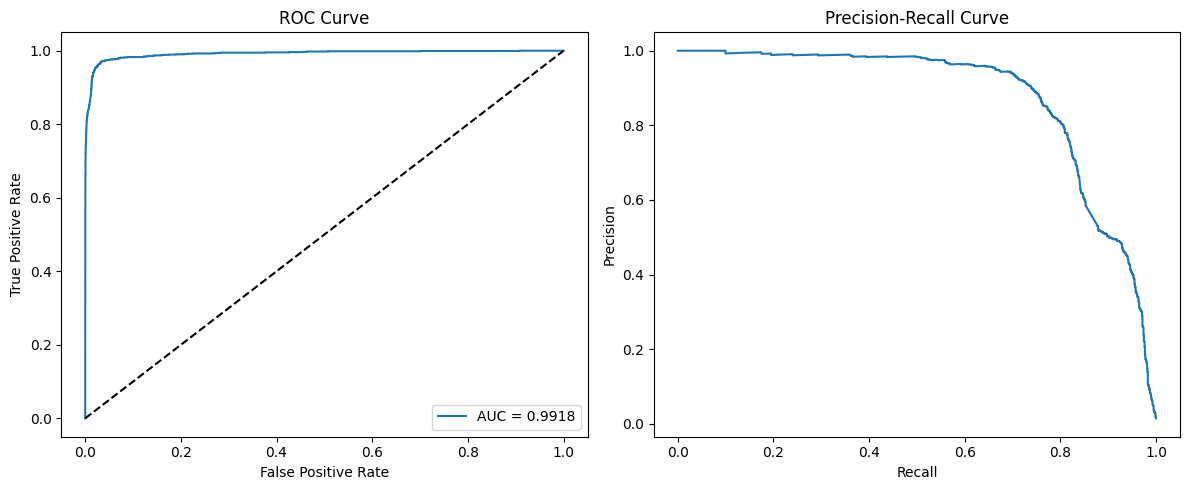

In [20]:
evaluate_model_on_features(model_path="best_model.pth", data_dir="val_dataset")
